# Train a CNN by reading batches of images from disk

You might need to train a model with so many images that it couldn't be feasible to train them from RAM.  
In that case, loading a group by a batch size might come handy.  
  

Here you will see how to do it by first loading the location of the images into a pandas dataframe, that could work as a "database source" and then reading it from disk, transform to grayscale, resize and turning it into a numpy array.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image #http://pillow.readthedocs.io/en/3.1.x/reference/Image.html
import os
import pandas as pd

Define functions to load an image, transform to gray scale, resize and turn it into a numpy array.

In [2]:
def rgbToG(img):
    """
    Color to gray
    """
    npImg=np.asarray(img)
    r=0.2125
    g=0.7154
    b=0.0721
    gsImg=r*npImg[:,:,0]+g*npImg[:,:,1]+b*npImg[:,:,2]
    return gsImg
def imgToGray(imgF,resize=True,w_h = (32,32)):
    """
    Open Image and 
    """
    img=Image.open(imgF)
    if resize==True:
        img = img.resize(w_h,Image.ANTIALIAS)
    imnp=np.asarray(img)
    img.close() #Close opened image
    ims=len(imnp.shape)
    if ims == 3:
        imgG=rgbToG(imnp)
    elif ims ==2:
        imgG=imnp
    return imgG



Define images repository and save the complete path plus the image to a list.  
We define the y_labels dictionary to transform the name 'dog,cat' into a dummies array  
that can be used by a softmax function

In [3]:
#Images source: https://www.kaggle.com/c/dogs-vs-cats/data

data='/home/bsaldivar/.../'

y_labels={'cat':np.array([[1, 0]]),'dog':np.array([[0, 1]])}
image_list = []

for f in os.listdir(data):
    target = f.split('.')[0]
    file_full=data+f
    image_list.append({'file':f,'file_full':file_full,'target':y_labels[target]})
    
        

Convert the list into a dataframe and then show the its content

In [4]:
image_df = pd.DataFrame(image_list)
print(image_df.head(10))

           file                         file_full    target
0  cat.1555.jpg  /home/bsaldivar/.../cat.1555.jpg  [[1, 0]]
1  cat.9666.jpg  /home/bsaldivar/.../cat.9666.jpg  [[1, 0]]
2  dog.7569.jpg  /home/bsaldivar/.../dog.7569.jpg  [[0, 1]]
3  cat.5661.jpg  /home/bsaldivar/.../cat.5661.jpg  [[1, 0]]
4  cat.5213.jpg  /home/bsaldivar/.../cat.5213.jpg  [[1, 0]]
5  cat.7355.jpg  /home/bsaldivar/.../cat.7355.jpg  [[1, 0]]
6  cat.7022.jpg  /home/bsaldivar/.../cat.7022.jpg  [[1, 0]]
7  cat.3681.jpg  /home/bsaldivar/.../cat.3681.jpg  [[1, 0]]
8  dog.7159.jpg  /home/bsaldivar/.../dog.7159.jpg  [[0, 1]]
9  dog.9138.jpg  /home/bsaldivar/.../dog.9138.jpg  [[0, 1]]


# Open an image alone to see its dimensions and try our function to transform to gray and resize into a numpy array from disk

/home/bsaldivar/.../train/cat.1555.jpg
(199, 150)
<class 'numpy.ndarray'> (32, 32)


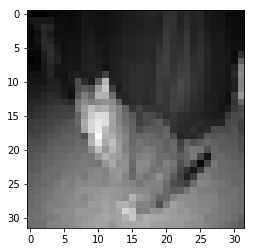

In [5]:
ix = image_df.loc[0]['file_full']
print(ix)
pix = Image.open(ix)
print(pix.size)
pix.close()

pix = imgToGray(ix,resize=True,w_h = (32,32))
print(type(pix),pix.shape)
plt.imshow(pix,cmap="gray")
plt.show()

# Test our by batch reading from disk and transform to numpy array

We have defined the limit number to just train from 20 records.

In [6]:

batch_size=5
limit=20
for _ in range(0,limit,batch_size):
    x_y = image_df.iloc[_:_+batch_size]
    fx = x_y['file_full'].values
    fy = x_y['target'].values

    z = list(map(imgToGray,fx))
    x = np.asarray(z)
    x = x.reshape([x.shape[0],x.shape[1],x.shape[2],1])
    
    y = np.concatenate(fy,0)
    
    print(x.shape,y.shape)


(5, 32, 32, 1) (5, 2)
(5, 32, 32, 1) (5, 2)
(5, 32, 32, 1) (5, 2)
(5, 32, 32, 1) (5, 2)


Now create a function to call it in a simpler way

In [7]:
def df_x_y (df,x_label,y_label,batch_size=5,offset=0):
    x_y = df.iloc[offset:offset+batch_size]
    fx = x_y[x_label].values
    fy = x_y[y_label].values
    z = list(map(imgToGray,fx))
    x = np.asarray(z)
    x = x.reshape([x.shape[0],x.shape[1],x.shape[2],1])
    y = np.concatenate(fy,0)
    return x,y

batch_size=5
limit=20

for _ in range(0,limit,batch_size):
    x_,y_ = df_x_y (image_df,x_label='file_full',y_label='target',batch_size=5,offset=_)
    print(x_.shape,y_.shape)

(5, 32, 32, 1) (5, 2)
(5, 32, 32, 1) (5, 2)
(5, 32, 32, 1) (5, 2)
(5, 32, 32, 1) (5, 2)


# Define layers for construction of a CNN

In [8]:

def get_previous_features(i_layer):
    convx_dims = i_layer.get_shape().as_list()
    output_features = 1
    for dim in range(1,len(convx_dims)):
        output_features=output_features*convx_dims[dim]
    return output_features



def conv(input_matrix,filter_size=3,layer_depth=8,
              strides=[1,1,1,1],padding='SAME',
              is_training=True,name_scope="lx",
              stddev_n = 0.05,
             max_bool=False,max_kernel=[1,2,2,1],max_strides=[1,1,1,1], max_padding='SAME',
             drop_out_bool=False,drop_out_ph=None,drop_out_v=None,decay=0.5
             ):
    with tf.name_scope(name_scope):
        ims = input_matrix.get_shape().as_list()
        input_depth=ims[len(ims)-1]
        W = tf.Variable(tf.truncated_normal([filter_size,filter_size,input_depth,layer_depth], stddev=stddev_n),name='W')
        b = tf.Variable(tf.constant(stddev_n, shape=[layer_depth]),name='b')
        c = tf.add(tf.nn.conv2d(input_matrix, W, strides=strides, padding=padding),b,name='conv')
        n = tf.contrib.layers.batch_norm(c, center=True, scale=True, is_training=is_training,decay=decay)
        a = tf.nn.relu(n,name="activation")
        if max_bool==True:
            out = tf.nn.max_pool(a, ksize=max_kernel,strides=max_strides, padding=max_padding,name='max')
        else:
            out = a
        if drop_out_bool==True:
            out_  = tf.nn.dropout(out, drop_out_ph)
        else:
            out_ = out
        return out_


def fc(input_matrix,n=22,norm=False,prev_conv=False,
       stddev_n = 0.05,is_training=True,
       name_scope='FC',drop_out_bool=False,drop_out_ph=None,drop_out_v=None,decay=0.5):
    with tf.name_scope(name_scope):
        cvpfx = get_previous_features(input_matrix)
        if prev_conv==True:
            im = tf.reshape(input_matrix, [-1, cvpfx])
        else:
            im = input_matrix
        W = tf.Variable(tf.truncated_normal([cvpfx, n], stddev=stddev_n),name='W')
        b = tf.Variable(tf.constant(stddev_n, shape=[n]),name='b') 
        fc = tf.add(tf.matmul(im, W),b,name="FC")
        if name_scope=="FCL":
            out_ = fc
        else:
            if norm==True:
                n = tf.contrib.layers.batch_norm(fc, center=True, scale=True, is_training=is_training,decay=decay)
                out = tf.nn.relu(n,name="activation")
            else:
                out = tf.nn.relu(fc,name="activation")
            if drop_out_bool==True:
                out_  = tf.nn.dropout(out, drop_out_ph)
            else:
                out_ = out
        return out_


# Define training function

In [9]:
def train(df,x_label,y_label,x_shape_,y_shape,
          batch_size=5,limit=20,
          iters=10,lr=0.001,save_model=True,save_name=None,restore_model=False,restore_name=None,v=False):
    """
    df: Dataframe that contains the image location in the x_label column, and the target dummies array in the y_label
    column. 
    x_shape_ and y_shape: shape of a batch for x and y, [None, 32,32,1] and [None,2] for grayscale channel 1, 
    and 2 target classes 
    v: for verbosity, if true show the loss progress
    """
    
    tf.reset_default_graph()
    class_output = y_shape[1]
    
    x_shape=[None]
    for _ in range(1,len(x_shape_)):
        x_shape.append(x_shape_[_])
    xi = tf.placeholder(tf.float32, shape=x_shape,name='x')
    y_ = tf.placeholder(tf.float32, shape=[None,class_output],name='y')
    train_bool=tf.placeholder(bool,name='train_test')
    learning_rate = tf.placeholder(tf.float32)
    
    #Define the model here--DOWN
    CV1 = conv(xi,filter_size=3,layer_depth=2,name_scope="CL1",is_training=train_bool)
    CV2 = conv(CV1,filter_size=3,layer_depth=2,name_scope="CL2",is_training=train_bool)
    prediction = fc(CV2,n=class_output,name_scope="FCL",prev_conv=True)
    #Define the model here--UP
    
    y_CNN = tf.nn.softmax(prediction,name='Softmax')
    class_pred = tf.argmax(y_CNN,1,name='ClassPred')
    loss = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_CNN), reduction_indices=[1]),name="loss")
    
    #The following three lines are required to make "is_training" work for normalization
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    init_op = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    
    with tf.Session() as s:
        if restore_model==True:
            if restore_name==None:
                print("No model file specified")
                return
            else:
                saver.restore(s,restore_dir)
        else:
            s.run(init_op)
        
        
        for __ in range(0,iters):
            #Read and transform to a numpy array images from disk by block
            for _ in range(0,limit,batch_size):
                x,y = df_x_y (df,'file_full','target',batch_size=batch_size,offset=_)
                fd={xi:x,y_:y,learning_rate:lr,train_bool:True}
                _t,l = s.run([train_step,loss],feed_dict=fd)
                if v==True:
                    print("Batch",_,"Iter:",__,"Loss:",l)
            
        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(s, save_name)
                print("Model saved in file: %s" % save_name)


Start the training process

In [10]:
xs = [None,32,32,1]
ys = [None,2]
train(image_df,'file_image','target',xs,ys,iters=10,lr=0.001,save_model=False,save_name=None,restore_model=False,restore_name=None,v=True)

Batch 0 Iter: 0 Loss: 0.422241
Batch 5 Iter: 0 Loss: 0.986407
Batch 10 Iter: 0 Loss: 2.02306
Batch 15 Iter: 0 Loss: 1.489
Batch 0 Iter: 1 Loss: 0.301701
Batch 5 Iter: 1 Loss: 0.503432
Batch 10 Iter: 1 Loss: 0.65972
Batch 15 Iter: 1 Loss: 0.628321
Batch 0 Iter: 2 Loss: 0.639722
Batch 5 Iter: 2 Loss: 0.500898
Batch 10 Iter: 2 Loss: 0.409604
Batch 15 Iter: 2 Loss: 0.466021
Batch 0 Iter: 3 Loss: 0.367195
Batch 5 Iter: 3 Loss: 0.201632
Batch 10 Iter: 3 Loss: 0.197201
Batch 15 Iter: 3 Loss: 0.558277
Batch 0 Iter: 4 Loss: 0.154518
Batch 5 Iter: 4 Loss: 0.13012
Batch 10 Iter: 4 Loss: 0.132147
Batch 15 Iter: 4 Loss: 0.518349
Batch 0 Iter: 5 Loss: 0.113399
Batch 5 Iter: 5 Loss: 0.10281
Batch 10 Iter: 5 Loss: 0.0989146
Batch 15 Iter: 5 Loss: 0.287876
Batch 0 Iter: 6 Loss: 0.10605
Batch 5 Iter: 6 Loss: 0.0756181
Batch 10 Iter: 6 Loss: 0.0848531
Batch 15 Iter: 6 Loss: 0.136071
Batch 0 Iter: 7 Loss: 0.112834
Batch 5 Iter: 7 Loss: 0.0641526
Batch 10 Iter: 7 Loss: 0.0733536
Batch 15 Iter: 7 Loss: 0.08